<a href="https://colab.research.google.com/github/stopdragonn/Toxicity/blob/main/H2O_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h2o scikit-learn matplotlib rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 11.9 MB/s eta 0:00:00


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 10 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,"14 days, 11 hours and 52 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_8ctxxs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.089 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Invalid SMILES: [*]OCC(CO[*])(CO[*])CO[*] |$_R1;;;;;;_R1;;;_R1;;;_R1$,lp:1:2,5:2,8:2,11:2,RG:_R1={*[H] |$_AP1;$|},{CCCCC(*)=O |$;;;;;_AP1;$,lp:6:2|},{CCCCCCCCC(*)=O |$;;;;;;;;;_AP1;$,lp:10:2|},{CCCCCCC(*)=O |$;;;;;;;_AP1;$,lp:8:2|}|
Invalid SMILES: 0
Invalid SMILES: 0


[08:04:14] SMILES Parse Error: syntax error while parsing: 0
[08:04:14] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[08:04:14] SMILES Parse Error: syntax error while parsing: 0
[08:04:14] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[08:04:15] WARNING: not removing hydrogen atom without neighbors
[08:04:15] WARNING: not removing hydrogen atom without neighbors
[08:04:15] SMILES Parse Error: syntax error while parsing: 0
[08:04:15] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[08:04:15] SMILES Parse Error: syntax error while parsing: 0
[08:04:15] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Invalid SMILES: 0
Invalid SMILES: 0


[08:04:15] SMILES Parse Error: syntax error while parsing: 0
[08:04:15] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Invalid SMILES: 0


[08:04:15] SMILES Parse Error: syntax error while parsing: 0
[08:04:15] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Invalid SMILES: 0
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
08:04:16.256: XGBoost_1_AutoML_3_20240724_80416 [XGBoost def_2] failed: java.lang.RuntimeException: Error while training XGBoost model

█
08:04:17.406: _train param, Dropping columns with too large numeric values: [Mol]
08:04:17.406: _train param, Training data must have at least 2 features (incl. response).
08:04:17.468: XGBoost_2_AutoML_3_20240724_80416 [XGBoost def_1] failed: java.lang.RuntimeException: Error while training XGBoost model
08:04:17.526: _train param, Dropping columns with too large numeric values: [Mol]
08:04:17.526: _train param, Training data must have at least 2 features (incl. response).
08:04:17.528: _train param, Dropping columns with too large numeric values: [Mol]
08:04:17.528: _train param, Training data must have at least 2 features (incl. response).
08:04:17.529: _train param, Dropping columns with too large numeric values: [Mo

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

Metadata saved to: models/20240724_172442/metadata.json


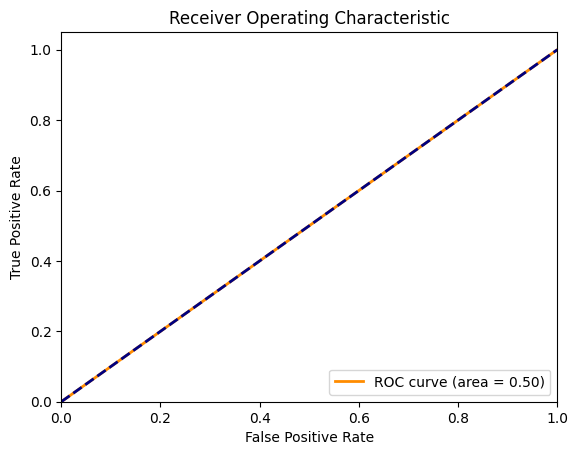

H2O session _sid_b5c5 closed.


<ipython-input-23-f0f6ff4bc16d>:25: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


In [23]:
import h2o
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, classification_report
from rdkit import Chem
from rdkit.Chem import MACCSkeys, AllChem, RDKFingerprint
import numpy as np
from sklearn.model_selection import train_test_split

class H2OManager:
    def __init__(self):
        self.h2o_instance = None

    def initialize(self):
        """Initialize the H2O cluster."""
        self.h2o_instance = h2o.init()

    def shutdown(self):
        """Shutdown the H2O cluster."""
        h2o.shutdown()

class FingerprintGenerator:
    def __init__(self, fingerprint_type):
        self.fingerprint_type = fingerprint_type

    def generate(self, mol):
        """Generate a fingerprint for a given molecule."""
        if not mol:
            return None
        if self.fingerprint_type == 'MACCS':
            return MACCSkeys.GenMACCSKeys(mol)
        elif self.fingerprint_type == 'Morgan':
            return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        elif self.fingerprint_type == 'RDKit':
            return RDKFingerprint(mol)
        elif self.fingerprint_type == 'Layered':
            return AllChem.LayeredFingerprint(mol)
        elif self.fingerprint_type == 'Pattern':
            return AllChem.PatternFingerprint(mol)
        else:
            raise ValueError(f"Unsupported fingerprint type: {self.fingerprint_type}")

    def generate_from_smiles(self, smiles_list, activities):
        """Generate fingerprints for the given SMILES list."""
        fingerprints = []
        valid_activities = []
        for smiles, activity in zip(smiles_list, activities):
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"Invalid SMILES: {smiles}")
                continue
            fp = self.generate(mol)
            if fp is not None:
                fingerprints.append(fp.ToBitString())
                valid_activities.append(activity)
        return fingerprints, valid_activities

class DataProcessor:
    def __init__(self, data):
        self.data = data

    def split_data(self):
        """Split the data into training and testing sets."""
        y = self.data['Toxicity'].values
        X = self.data['SMILES'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        return X_train, X_test, y_train, y_test

    @staticmethod
    def create_h2o_frame(fingerprints, activities):
        """Create an H2O frame from the given fingerprints and activities."""
        data_dict = {
            'Mol': fingerprints,
            'Activity': activities
        }
        return H2OFrame(pd.DataFrame(data_dict))

class AutoMLRunner:
    def __init__(self, max_models=20, seed=1):
        self.max_models = max_models
        self.seed = seed
        self.automl = H2OAutoML(max_models=self.max_models, seed=self.seed, balance_classes=True)

    def run(self, fingerprints, activities):
        """Run H2O AutoML on the given fingerprints and activities."""
        h2o_frame = DataProcessor.create_h2o_frame(fingerprints, activities)
        h2o_frame['Activity'] = h2o_frame['Activity'].asfactor()  # Convert to categorical for classification
        target_column = "Activity"
        feature_columns = ['Mol']
        self.automl.train(x=feature_columns, y=target_column, training_frame=h2o_frame)
        return self.automl

    def evaluate_and_save_model(self, automl, test_data, save_directory):
        """Evaluate the best model and save its performance metrics and plots."""
        best_model = automl.leader
        performance = best_model.model_performance(test_data)
        print("Performance on test data:", performance)

        # Calculate classification report
        predictions = best_model.predict(test_data)
        y_true = test_data['Activity'].as_data_frame()['Activity']
        y_pred = predictions["predict"].as_data_frame()['predict']
        report = classification_report(y_true, y_pred, output_dict=True)

        # Save metadata
        metadata = {
            "model_path": save_directory,
            "params": best_model.get_params(),
            "performance": performance.rmse(),
            "classification_report": report,
            "timestamp": (datetime.now(timezone(timedelta(hours=9)))).strftime("%Y%m%d_%H%M%S")  # KST
        }
        metadata_path = os.path.join(save_directory, "metadata.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f)
        print(f"Metadata saved to: {metadata_path}")

        # Plot and save ROC curve
        fpr, tpr, _ = roc_curve(test_data['Activity'].as_data_frame(), predictions["p1"].as_data_frame())
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(save_directory, "roc_curve.png"))
        plt.show()

def main():
    h2o_manager = H2OManager()
    h2o_manager.initialize()

    # Example data load
    data = pd.read_csv('/content/drive/MyDrive/H2O_AutoML/tg414.csv')
    data_processor = DataProcessor(data)

    X_train, X_test, y_train, y_test = data_processor.split_data()

    # Generate MACCS fingerprints
    fingerprint_generator = FingerprintGenerator('MACCS')
    train_fingerprints, y_train = fingerprint_generator.generate_from_smiles(X_train, y_train)
    test_fingerprints, y_test = fingerprint_generator.generate_from_smiles(X_test, y_test)

    # Run AutoML
    automl_runner = AutoMLRunner()
    automl = automl_runner.run(train_fingerprints, y_train)

    # Create directory for saving model and results
    current_time = datetime.now(timezone(timedelta(hours=9))).strftime("%Y%m%d_%H%M%S")  # KST
    save_directory = os.path.join("models", current_time)
    os.makedirs(save_directory, exist_ok=True)

    # Evaluate and save model
    test_data_h2o = DataProcessor.create_h2o_frame(test_fingerprints, y_test)
    test_data_h2o['Activity'] = test_data_h2o['Activity'].asfactor()  # Convert to categorical for classification
    automl_runner.evaluate_and_save_model(automl, test_data_h2o, save_directory)

    # Shutdown H2O cluster
    h2o_manager.shutdown()

if __name__ == "__main__":
    main()


In [25]:
data = pd.read_csv('/content/drive/MyDrive/H2O_AutoML/tg414.csv')
print(data.head())


        CasRN           DTXSID  \
0  24347-58-8  DTXSID801031371   
1   5341-95-7  DTXSID301031540   
2    108-32-7    DTXSID2026789   
3  56554-53-1   DTXSID10971994   
4  13241-33-3   DTXSID60927668   

                                              SMILES  Toxicity  
0                               C[C@@H](O)[C@@H](C)O         0  
1                                C[C@@H](O)[C@H](C)O         0  
2                                       CC1COC(=O)O1         0  
3  CC(CC(=O)OCC(COC(=O)CC(C)CC(C)(C)C)OC(=O)CC(C)...         0  
4  [H][C@@]1(O[C@@H]2[C@@H](O)[C@H](O)[C@@H](CO)O...         0  


In [27]:
import h2o
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, classification_report
from rdkit import Chem
from rdkit.Chem import MACCSkeys, AllChem, RDKFingerprint
import numpy as np
from sklearn.model_selection import train_test_split

class H2OManager:
    def __init__(self):
        self.h2o_instance = None

    def initialize(self):
        """Initialize the H2O cluster."""
        self.h2o_instance = h2o.init()

    def shutdown(self):
        """Shutdown the H2O cluster."""
        h2o.cluster().shutdown()

class FingerprintGenerator:
    def __init__(self, fingerprint_type):
        self.fingerprint_type = fingerprint_type

    def generate(self, mol):
        """Generate a fingerprint for a given molecule."""
        if not mol:
            return None
        if self.fingerprint_type == 'MACCS':
            return MACCSkeys.GenMACCSKeys(mol)
        elif self.fingerprint_type == 'Morgan':
            return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        elif self.fingerprint_type == 'RDKit':
            return RDKFingerprint(mol)
        elif self.fingerprint_type == 'Layered':
            return AllChem.LayeredFingerprint(mol)
        elif self.fingerprint_type == 'Pattern':
            return AllChem.PatternFingerprint(mol)
        else:
            raise ValueError(f"Unsupported fingerprint type: {self.fingerprint_type}")

    def generate_from_smiles(self, smiles_list, activities):
        """Generate fingerprints for the given SMILES list."""
        fingerprints = []
        valid_activities = []
        for smiles, activity in zip(smiles_list, activities):
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"Invalid SMILES: {smiles}")
                continue
            fp = self.generate(mol)
            if fp is not None:
                fingerprints.append(fp.ToBitString())
                valid_activities.append(activity)
        return fingerprints, valid_activities

class DataProcessor:
    def __init__(self, data):
        self.data = data

    def split_data(self):
        """Split the data into training and testing sets."""
        y = self.data['Toxicity'].values
        X = self.data['SMILES'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        return X_train, X_test, y_train, y_test

    @staticmethod
    def create_h2o_frame(fingerprints, activities):
        """Create an H2O frame from the given fingerprints and activities."""
        data_dict = {
            'Mol': fingerprints,
            'Activity': activities
        }
        return H2OFrame(pd.DataFrame(data_dict))

class AutoMLRunner:
    def __init__(self, max_models=20, seed=1):
        self.max_models = max_models
        self.seed = seed
        self.automl = H2OAutoML(max_models=self.max_models, seed=self.seed, balance_classes=True)

    def run(self, fingerprints, activities):
        """Run H2O AutoML on the given fingerprints and activities."""
        h2o_frame = DataProcessor.create_h2o_frame(fingerprints, activities)
        h2o_frame['Activity'] = h2o_frame['Activity'].asfactor()  # Convert to categorical for classification
        h2o_frame['Mol'] = h2o_frame['Mol'].ascharacter()  # Ensure Mol is treated as character
        target_column = "Activity"
        feature_columns = ['Mol']
        self.automl.train(x=feature_columns, y=target_column, training_frame=h2o_frame)
        return self.automl

    def evaluate_and_save_model(self, automl, test_data, save_directory):
        """Evaluate the best model and save its performance metrics and plots."""
        best_model = automl.leader
        performance = best_model.model_performance(test_data)
        print("Performance on test data:", performance)

        # Calculate classification report
        predictions = best_model.predict(test_data)
        y_true = test_data['Activity'].as_data_frame()['Activity']
        y_pred = predictions["predict"].as_data_frame()['predict']
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

        # Save metadata
        metadata = {
            "model_path": save_directory,
            "params": best_model.get_params(),
            "performance": performance.rmse(),
            "classification_report": report,
            "timestamp": (datetime.now(timezone(timedelta(hours=9)))).strftime("%Y%m%d_%H%M%S")  # KST
        }
        metadata_path = os.path.join(save_directory, "metadata.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f)
        print(f"Metadata saved to: {metadata_path}")

        # Plot and save ROC curve
        y_true_bin = (y_true == 1).astype(int)
        y_pred_prob = predictions["p1"].as_data_frame()['p1']
        fpr, tpr, _ = roc_curve(y_true_bin, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(save_directory, "roc_curve.png"))
        plt.show()

def main():
    h2o_manager = H2OManager()
    h2o_manager.initialize()

    # Example data load
    data = pd.read_csv('/content/drive/MyDrive/H2O_AutoML/tg414.csv')
    data_processor = DataProcessor(data)

    X_train, X_test, y_train, y_test = data_processor.split_data()

    # Generate MACCS fingerprints
    fingerprint_generator = FingerprintGenerator('MACCS')
    train_fingerprints, y_train = fingerprint_generator.generate_from_smiles(X_train, y_train)
    test_fingerprints, y_test = fingerprint_generator.generate_from_smiles(X_test, y_test)

    # Ensure valid data length
    min_length = min(len(train_fingerprints), len(y_train))
    train_fingerprints = train_fingerprints[:min_length]
    y_train = y_train[:min_length]

    min_length = min(len(test_fingerprints), len(y_test))
    test_fingerprints = test_fingerprints[:min_length]
    y_test = y_test[:min_length]

    # Run AutoML
    automl_runner = AutoMLRunner()
    automl = automl_runner.run(train_fingerprints, y_train)

    # Create directory for saving model and results
    current_time = datetime.now(timezone(timedelta(hours=9))).strftime("%Y%m%d_%H%M%S")  # KST
    save_directory = os.path.join("models", current_time)
    os.makedirs(save_directory, exist_ok=True)

    # Evaluate and save model
    test_data_h2o = DataProcessor.create_h2o_frame(test_fingerprints, y_test)
    test_data_h2o['Activity'] = test_data_h2o['Activity'].asfactor()  # Convert to categorical for classification
    automl_runner.evaluate_and_save_model(automl, test_data_h2o, save_directory)

    # Shutdown H2O cluster
    h2o_manager.shutdown()

if __name__ == "__main__":
    main()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,33 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,"14 days, 12 hours and 44 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_ack7bq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Invalid SMILES: [*]OCC(CO[*])(CO[*])CO[*] |$_R1;;;;;;_R1;;;_R1;;;_R1$,lp:1:2,5:2,8:2,11:2,RG:_R1={*[H] |$_AP1;$|},{CCCCC(*)=O |$;;;;;_AP1;$,lp:6:2|},{CCCCCCCCC(*)=O |$;;;;;;;;;_AP1;$,lp:10:2|},{CCCCCCC(*)=O |$;;;;;;;_AP1;$,lp:8:2|}|
Invalid SMILES: 0
Invalid SMILES: 0


[08:55:26] SMILES Parse Error: syntax error while parsing: 0
[08:55:26] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[08:55:26] SMILES Parse Error: syntax error while parsing: 0
[08:55:26] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[08:55:26] WARNING: not removing hydrogen atom without neighbors
[08:55:26] WARNING: not removing hydrogen atom without neighbors
[08:55:26] SMILES Parse Error: syntax error while parsing: 0
[08:55:26] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'
[08:55:27] SMILES Parse Error: syntax error while parsing: 0
[08:55:27] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Invalid SMILES: 0
Invalid SMILES: 0


[08:55:27] SMILES Parse Error: syntax error while parsing: 0
[08:55:27] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Invalid SMILES: 0


[08:55:27] SMILES Parse Error: syntax error while parsing: 0
[08:55:27] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


Invalid SMILES: 0
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: | (failed)

08:55:30.556: _train param, Dropping bad and constant columns: [Mol]
08:55:30.556: _train param, Training data must have at least 2 features (incl. response).
08:55:30.605: _train param, Dropping bad and constant columns: [Mol]
08:55:30.605: _train param, Training data must have at least 2 features (incl. response).
08:55:30.631: _train param, Dropping bad and constant columns: [Mol]
08:55:30.631: _train param, Training data must have at least 2 features (incl. response).
08:55:30.654: _train param, Dropping bad and constant columns: [Mol]
08:55:30.655: _train param, Training data must have at least 2 features (incl. response).
08:55:30.671: _train param, Dropping bad and constant columns: [Mol]
08:55:30.671: _train param, Training data must have at least 2 features (incl. response).
08:55:30.687: _train param, Dropping bad and constant columns: 

OSError: Job with key $03017f00000132d4ffffffff$_8ffdbcb908e239b44525ed97b5fc4989 failed with an exception: water.exceptions.H2OAutoMLException: Aborting AutoML after too many consecutive model failures
stacktrace: 
water.exceptions.H2OAutoMLException: Aborting AutoML after too many consecutive model failures
	at ai.h2o.automl.AutoML.learn(AutoML.java:776)
	at ai.h2o.automl.AutoML.run(AutoML.java:494)
	at ai.h2o.automl.H2OJob$1.compute2(H2OJob.java:33)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1704)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
